# 玉山人工智慧公開挑戰賽#1 - 金融商品交易預測

1. 訓練資料集時間為 9447+1 (9448) ~ 9447+120 (9567) 之間，共120日之間產品交易/申請資訊<br/>
2. 本次比賽是請參賽者預測在9447+121 (9568) ~ 9447+150 (9597) 時間區間內（共30日），顧客在四個產品線CC_IND, FX_IND, LN_IND, WM_IND是否會進行交易，若預測顧客該時間內於任一產品線交易一次以上，該產品線的預測值為1，否則為0．例如: 顧客序號12345，預測信用卡核卡1次，外匯交易2次，沒有信貸申請，信託交易3次，該筆預測資料應為: 12345,1,1,0,1 ．<br/>
3. TBN_Y_ZERO.csv則是提供給參賽者做為上傳範例資料檔使用，內部預設值是全部為0．

### 問題聚焦
得分方式(f1_score):<br/>
產品權重:外匯=1, 信用卡=10, 信託類產品=20, 信貸=20
(產品權重)*各產品預測結果的 f1_score 總和

Score = FX_f1\*1 + CC_f1\*10 + WM_f1\*20 + LN_f1\*20

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 匯入檔案

In [2]:
df_CIF = pd.read_csv("/home/jovyan/TBN bank predict/TBN_CIF.csv")
df_CUST_BEHAVIOR = pd.read_csv("/home/jovyan/TBN bank predict/TBN_CUST_BEHAVIOR.csv")
df_RECENT_DT = pd.read_csv("/home/jovyan/TBN bank predict/TBN_RECENT_DT.csv")
#前三個月當作訓練資料
train_test_interval =9537

df_CC_APPLY = pd.read_csv("/home/jovyan/TBN bank predict/TBN_CC_APPLY.csv")
df_FX_TXN = pd.read_csv("/home/jovyan/TBN bank predict/TBN_FX_TXN.csv")
df_LN_APPLY = pd.read_csv("/home/jovyan/TBN bank predict/TBN_LN_APPLY.csv")
df_WM_TXN = pd.read_csv("/home/jovyan/TBN bank predict/TBN_WM_TXN.csv")

df_TBN_Y_ZERO = pd.read_csv("/home/jovyan/TBN bank predict/TBN_Y_ZERO.csv")

## 處理資料遺失值及彙整

step1. 處理df_CIF <br/>
step2. 將df_CIF  df_TBN_Y_ZERO 結合成result <br/>
step3. 處理df_CUST_BEHAVIOR <br/>
step4. 處理df_RECENT_DT <br/>
step5. 將df_CUST_BEHAVIOR,df_RECENT_DT 與result合併 <br/>
step6. 處理 df_CC_APPLY,df_FX_TXN, df_LN_APPLY, df_WM_TXN <br/>
step7. df_CC_APPLY_train,df_FX_TXN_train, df_LN_APPLY_train, df_WM_TXN_train 與result合併 <br/>
step8. 處理df_CC_APPLY_test,df_FX_TXN_test, df_LN_APPLY_test, df_WM_TXN_test

In [3]:
# step1.處理df_CIF
df_CIF["CHILDREN_CNT"] = df_CIF["CHILDREN_CNT"].fillna(df_CIF["CHILDREN_CNT"].mode()[0])

df_CIF.loc[(df_CIF["INCOME_RANGE_CODE"].isnull()) & (df_CIF["CUST_START_DT"]>=6479),"INCOME_RANGE_CODE"] = 1.0
df_CIF.loc[(df_CIF["INCOME_RANGE_CODE"].isnull()) & (df_CIF["CUST_START_DT"]<6479)& (df_CIF["CUST_START_DT"]>=5245),"INCOME_RANGE_CODE"] = 2.0
df_CIF.loc[(df_CIF["INCOME_RANGE_CODE"].isnull()) & (df_CIF["CUST_START_DT"]<5245)& (df_CIF["CUST_START_DT"]>=4812),"INCOME_RANGE_CODE"] = 3.0
df_CIF.loc[(df_CIF["INCOME_RANGE_CODE"].isnull()) & (df_CIF["CUST_START_DT"]<4812),"INCOME_RANGE_CODE"] = 4.0

# EDU_CODE >3設為女性 , 其餘為男性
df_CIF.loc[(df_CIF["GENDER_CODE"].isnull()) & (df_CIF["EDU_CODE"]>=3),"GENDER_CODE"] = 'F'
df_CIF["GENDER_CODE"]= df_CIF["GENDER_CODE"].fillna('M')

# WORK_MTHS=2 map到 年齡4 
df_CIF.loc[(df_CIF["WORK_MTHS"].isnull()) & (df_CIF["AGE"]==4 ),"WORK_MTHS"] =2
# WORK_MTHS=2 map到 EDU_CODE >4 
df_CIF.loc[(df_CIF["WORK_MTHS"].isnull()) & (df_CIF["EDU_CODE"]>4 ),"WORK_MTHS"] =2
# WORK_MTHS=2 map到 CHILDREN_CNT >0 
df_CIF.loc[(df_CIF["WORK_MTHS"].isnull()) & (df_CIF["CHILDREN_CNT"]>0 ),"WORK_MTHS"] =2
# WORK_MTHS=2 map到 CHILDREN_CNT >0 
df_CIF.loc[(df_CIF["WORK_MTHS"].isnull()) & (df_CIF["CUST_START_DT"]<5000 ),"WORK_MTHS"] =2
# WORK_MTHS=2 map到 CHILDREN_CNT >0 
df_CIF.loc[(df_CIF["WORK_MTHS"].isnull()) & (df_CIF["INCOME_RANGE_CODE"]>1 ),"WORK_MTHS"] =2
#其餘的填入 WORK_MTHS=1
df_CIF["WORK_MTHS"]= df_CIF["WORK_MTHS"].fillna(df_CIF["WORK_MTHS"].mode()[0])


# EDU_CODE=1 map到 INCOME_RANGE_CODE >1 
df_CIF.loc[(df_CIF["EDU_CODE"].isnull()) & (df_CIF["INCOME_RANGE_CODE"]>1 ),"EDU_CODE"] =1
# EDU_CODE=6 map到 CUST_START_DT >7000
df_CIF.loc[(df_CIF["EDU_CODE"].isnull()) & (df_CIF["CUST_START_DT"]>7000 ),"EDU_CODE"] =6
# EDU_CODE=4 map到 AGE >3 可以推斷為EDU_CODE為1 or 4,但4樣本數較多 
df_CIF.loc[(df_CIF["EDU_CODE"].isnull()) & (df_CIF["AGE"]>2 ),"EDU_CODE"] =4
#其餘的填入 WORK_MTHS=mode
df_CIF["EDU_CODE"]= df_CIF["EDU_CODE"].fillna(df_CIF["EDU_CODE"].mode()[0])

In [4]:
df_CIF.isnull().sum()

CUST_NO              0
AGE                  0
CHILDREN_CNT         0
CUST_START_DT        0
EDU_CODE             0
GENDER_CODE          0
INCOME_RANGE_CODE    0
WORK_MTHS            0
dtype: int64

In [5]:
# step2. 將df_CIF  df_TBN_Y_ZERO 結合成result
result = pd.merge(df_TBN_Y_ZERO[["CUST_NO"]], df_CIF, how='left', on=['CUST_NO'])

In [6]:
for i in result.columns:
    result[i]=result[i].fillna(result[i].mode()[0])
result.isnull().sum()

CUST_NO              0
AGE                  0
CHILDREN_CNT         0
CUST_START_DT        0
EDU_CODE             0
GENDER_CODE          0
INCOME_RANGE_CODE    0
WORK_MTHS            0
dtype: int64

In [7]:
#step3. 處理df_CUST_BEHAVIOR
df_CUST_BEHAVIOR_train = df_CUST_BEHAVIOR[df_CUST_BEHAVIOR["VISITDATE"].values<train_test_interval]
df_CUST_BEHAVIOR_train = df_CUST_BEHAVIOR_train.groupby("CUST_NO").count()[["VISITDATE"]]

In [8]:
#step4. 處理df_RECENT_DT
for i in df_RECENT_DT.columns[1:]:
    df_RECENT_DT.loc[df_RECENT_DT[i]>0,i] = 1
    df_RECENT_DT[i] = df_RECENT_DT[i].fillna(0)

In [9]:
# 將df_CUST_BEHAVIOR,df_RECENT_DT 與result合併
result = pd.merge(result, df_CUST_BEHAVIOR_train, how='left', on=['CUST_NO'])
result = pd.merge(result, df_RECENT_DT, how='left', on=['CUST_NO'])

In [10]:
result.isnull().sum()

CUST_NO                  0
AGE                      0
CHILDREN_CNT             0
CUST_START_DT            0
EDU_CODE                 0
GENDER_CODE              0
INCOME_RANGE_CODE        0
WORK_MTHS                0
VISITDATE            15134
CC_RECENT_DT             0
FX_RECENT_DT             0
LN_RECENT_DT             0
WM_RECENT_DT             0
dtype: int64

In [11]:
result["VISITDATE"] = result["VISITDATE"].fillna(0)
result = result.rename(index=str, columns={"VISITDATE": "VISIT_TIMES"})

In [12]:
result.isnull().sum()

CUST_NO              0
AGE                  0
CHILDREN_CNT         0
CUST_START_DT        0
EDU_CODE             0
GENDER_CODE          0
INCOME_RANGE_CODE    0
WORK_MTHS            0
VISIT_TIMES          0
CC_RECENT_DT         0
FX_RECENT_DT         0
LN_RECENT_DT         0
WM_RECENT_DT         0
dtype: int64

In [13]:
# step6. 處理 df_CC_APPLY,df_FX_TXN, df_LN_APPLY, df_WM_TXN
df_CC_APPLY_train = df_CC_APPLY[df_CC_APPLY["TXN_DT"].values<train_test_interval]
df_FX_TXN_train = df_FX_TXN[df_FX_TXN["TXN_DT"].values<train_test_interval]
df_LN_APPLY_train = df_LN_APPLY[df_LN_APPLY["TXN_DT"].values<train_test_interval]
df_WM_TXN_train = df_WM_TXN[df_WM_TXN["TXN_DT"].values<train_test_interval]

In [14]:
#step7. df_CC_APPLY,df_FX_TXN, df_LN_APPLY, df_WM_TXN 與result合併

result = pd.merge(result, df_CC_APPLY_train.groupby("CUST_NO").count()[["TXN_DT"]], how='left', on=['CUST_NO'])
result = result.rename(index=str, columns={"TXN_DT": "CC_Applied_Nums"})

result = pd.merge(result, df_FX_TXN_train.groupby("CUST_NO").count()[["TXN_DT"]], how='left', on=['CUST_NO'])
result = result.rename(index=str, columns={"TXN_DT": "FX_Applied_Nums"})

result = pd.merge(result, df_LN_APPLY_train.groupby("CUST_NO").count()[["TXN_DT"]], how='left', on=['CUST_NO'])
result = result.rename(index=str, columns={"TXN_DT": "LN_Applied_Nums"})

result = pd.merge(result, df_WM_TXN_train.groupby("CUST_NO").count()[["TXN_DT"]], how='left', on=['CUST_NO'])
result = result.rename(index=str, columns={"TXN_DT": "WM_Applied_Nums"})

In [15]:
applied_nums = ["CC_Applied_Nums", "FX_Applied_Nums", "LN_Applied_Nums", "WM_Applied_Nums"]

for i in applied_nums:
    result[i] = result[i].fillna(0)

result.isnull().sum()

CUST_NO              0
AGE                  0
CHILDREN_CNT         0
CUST_START_DT        0
EDU_CODE             0
GENDER_CODE          0
INCOME_RANGE_CODE    0
WORK_MTHS            0
VISIT_TIMES          0
CC_RECENT_DT         0
FX_RECENT_DT         0
LN_RECENT_DT         0
WM_RECENT_DT         0
CC_Applied_Nums      0
FX_Applied_Nums      0
LN_Applied_Nums      0
WM_Applied_Nums      0
dtype: int64

In [16]:
#step8. 處理df_CC_APPLY_test,df_FX_TXN_test, df_LN_APPLY_test, df_WM_TXN_test
df_CC_APPLY_test = df_CC_APPLY[df_CC_APPLY["TXN_DT"].values>train_test_interval]
df_FX_TXN_test = df_FX_TXN[df_FX_TXN["TXN_DT"].values>train_test_interval]
df_LN_APPLY_test = df_LN_APPLY[df_LN_APPLY["TXN_DT"].values>train_test_interval]
df_WM_TXN_test = df_WM_TXN[df_WM_TXN["TXN_DT"].values>train_test_interval]

df_CC_APPLY_test_groupby = df_CC_APPLY_test.groupby("CUST_NO").count()
df_CC_APPLY_test_groupby["Next_Applied"]=1

df_FX_APPLY_test_groupby = df_FX_TXN_test.groupby("CUST_NO").count()
df_FX_APPLY_test_groupby["Next_Applied"]=1

df_LN_APPLY_test_groupby = df_LN_APPLY_test.groupby("CUST_NO").count()
df_LN_APPLY_test_groupby["Next_Applied"]=1

df_WM_APPLY_test_groupby = df_WM_TXN_test.groupby("CUST_NO").count()
df_WM_APPLY_test_groupby["Next_Applied"]=1


In [17]:
df_CC_APPLY_test_y = pd.merge(df_TBN_Y_ZERO[["CUST_NO"]], df_CC_APPLY_test_groupby[["Next_Applied"]], how='left', on=['CUST_NO'])
df_FX_APPLY_test_y = pd.merge(df_TBN_Y_ZERO[["CUST_NO"]], df_FX_APPLY_test_groupby[["Next_Applied"]], how='left', on=['CUST_NO'])
df_LN_APPLY_test_y = pd.merge(df_TBN_Y_ZERO[["CUST_NO"]], df_LN_APPLY_test_groupby[["Next_Applied"]], how='left', on=['CUST_NO'])
df_WM_APPLY_test_y = pd.merge(df_TBN_Y_ZERO[["CUST_NO"]], df_WM_APPLY_test_groupby[["Next_Applied"]], how='left', on=['CUST_NO'])

all_test_y=[df_CC_APPLY_test_y,df_FX_APPLY_test_y, df_LN_APPLY_test_y, df_WM_APPLY_test_y ]

In [18]:
for i in all_test_y:
    i["Next_Applied"] = i["Next_Applied"].fillna(0)

## 處理skewness及正則化

In [19]:
result.head()

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,VISIT_TIMES,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,CC_Applied_Nums,FX_Applied_Nums,LN_Applied_Nums,WM_Applied_Nums
0,_PT5HFBEZJKOZ934,4.0,0.0,2912.0,4.0,F,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6STXUMWZRDCGSDDU,2.0,0.0,7686.0,3.0,M,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JDVF4U8JUANEID68,4.0,0.0,2484.0,3.0,F,4.0,1.0,42.0,1.0,1.0,0.0,1.0,0.0,11.0,0.0,0.0
3,8I6SQDGP9OQYUN1M,1.0,0.0,7754.0,6.0,F,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,R-TRDUV3GHTID31I,4.0,0.0,4062.0,2.0,M,1.0,1.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


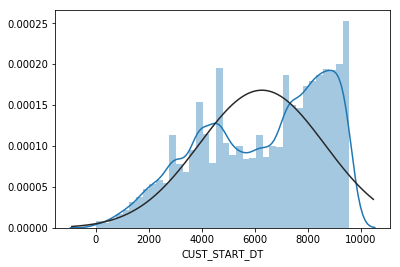

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from scipy.stats import norm
sns.distplot(result['CUST_START_DT'], fit=norm);

In [21]:
saleprice_scaled = MinMaxScaler().fit_transform(result['CUST_START_DT'][:,np.newaxis]);
#雙峰轉常態~還沒弄

In [22]:
result['CUST_START_DT'] = saleprice_scaled

## 使用 OneHotEncoder (GENDER_CODE)

In [23]:
result = pd.concat([result, pd.get_dummies(result['GENDER_CODE'])], axis=1);

In [24]:
result = result.drop("GENDER_CODE", axis=1)

In [25]:
result.head()

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,INCOME_RANGE_CODE,WORK_MTHS,VISIT_TIMES,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,CC_Applied_Nums,FX_Applied_Nums,LN_Applied_Nums,WM_Applied_Nums,F,M
0,_PT5HFBEZJKOZ934,4.0,0.0,0.304380,4.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,6STXUMWZRDCGSDDU,2.0,0.0,0.803387,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,JDVF4U8JUANEID68,4.0,0.0,0.259643,3.0,4.0,1.0,42.0,1.0,1.0,0.0,1.0,0.0,11.0,0.0,0.0,1,0
3,8I6SQDGP9OQYUN1M,1.0,0.0,0.810494,6.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0
4,R-TRDUV3GHTID31I,4.0,0.0,0.424585,2.0,1.0,1.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1


## Model(XGBOOST)

In [26]:
result= result.drop("CUST_NO", axis=1)

In [38]:
import warnings
warnings.filterwarnings('ignore')

import time
import datetime
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [90]:
#'colsample_bytree':[ 0.1 , 0.2,  0.3],'n_estimators':[300,700,1100],'max_depth':[3,4,5]
# 測試1 :xgb_param_grid = {'n_estimators':[500], 'colsample_bytree':[ 0.1 , 0.2,  0.3, 0.4, 0.5]} colsample_bytree=0.4最好
# 測試2 :xgb_param_grid = {'n_estimators':[500], 'colsample_bytree':[ 0.35, 0.4, 0.45]} colsample_bytree=0.45最好
# 測試3 :xgb_param_grid = {'n_estimators':[450,500,550], 'colsample_bytree':[0.4, 0.45, 0.5]} colsample_bytree=0.45, n_estimators=550最好
# 測試4 :xgb_param_grid = {'n_estimators':[550,600, 650], 'colsample_bytree':[0.45]} n_estimators=550最好
# 測試5 :xgb_param_grid = {'n_estimators':[550,600,650, 750, 850], 'colsample_bytree':[0.45],'max_depth':[3,4,5]} n_estimators=750 max_depth=5最好
# 測試6 :xgb_param_grid = {'n_estimators':[700, 750, 800], 'colsample_bytree':[0.45],'max_depth':[5,6,7]} n_estimators=800 max_depth=7最好
# 測試7 :xgb_param_grid = {'max_depth': [7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]} min_child_weight=4,max_depth=9
# 測試8 :xgb_param_grid = {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 'subsample': [0.6, 0.7, 0.8, 0.9]} gamma=0 subsample=0.6
# 測試8 :xgb_param_grid = {'subsample': [0.0, 0.1, 0.3]} subsample 0.3最好
# 測試9 :xgb_param_grid = {'subsample': [0.2, 0.3, 0.4, 0.5]} subsample 0.5最好
# 測試10 :xgb_param_grid = {'subsample': [0.45, 0.5, 0.55, 0.6]} subsample 0.6最好
# 測試11 :xgb_param_grid = {'subsample': [0.6, 0.65, 0.7]} subsample 0.6最好
# 測試12 :xgb_param_grid = {'n_estimators':[750, 800, 850, 900], 'colsample_bytree':[0.4, 0.45, 0.5]} n_estimators=900 colsample_bytree=0.5最好
# 測試13 :xgb_param_grid = {'n_estimators':[850, 900, 950, 100], 'colsample_bytree':[0.45, 0.5, 0.55 ,0.6]} n_estimators=900 colsample_bytree=0.5最好
xgb_param_grid = {'min_child_weight': [1, 2, 3, 4, 5, 6],'colsample_bytree':[ 1 ,0.9 ,0.8]} #colsample_bytree=1, min_child_weight=2
other_params = {'learning_rate': 0.02,  'n_estimators':900, 'seed': 0, 'max_depth':9}

In [91]:
xgb_inst= xgb.XGBClassifier(**other_params)

In [92]:
xgb_grid = GridSearchCV(estimator= xgb_inst, param_grid = xgb_param_grid,scoring='f1', cv=3, verbose=1)

In [93]:
start_time = datetime.datetime.now()
print(start_time)
xgb_grid.fit(result,df_CC_APPLY_test_y["Next_Applied"])
end_time=datetime.datetime.now()
print(end_time)
print("--- %s seconds ---" % (end_time - start_time))

2019-02-23 03:21:00.780747
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 14.8min finished


2019-02-23 03:36:10.838410
--- 0:15:10.057663 seconds ---


In [96]:
xgb_results = xgb_grid.cv_results_
np.max(xgb_results["mean_test_score"])

0.2514604396854022

In [94]:
np.max(xgb_results["mean_test_score"])

0.23750483320633375

In [95]:
xgb_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=9, min_child_weight=2, missing=None, n_estimators=900,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [97]:
import pickle

#保存Model
with open('CC_xgb_grid.pickle', 'wb') as f:
    pickle.dump(xgb_grid, f)
   

'''


'''

'\n\n\n'

In [87]:
#读取Model
with open('CC_xgb_grid_v2.pickle', 'rb') as f:
    xgb_grid = pickle.load(f)
    #测试读取后的Model
    #print(xgb_grid.predict(X[0:1]))